# Imports

Requirements:
- numpy
- pystan
- scipy
- pickle
- rpy2
- seroprevalence (included .py)
- util (included .py)

In [8]:
import numpy as np
import pystan
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import beta
import pickle

# Figures
import matplotlib.pyplot as plt
from util import *

# Helpers

In [9]:
# Plotting helper to take samples and make a smoothed histogram line plot.
def process(X,filterwidth=2,bins=100,CI_width=95):
    counts, bins = np.histogram(X,bins=bins,density=True,)
    midpoints = (bins[:-1]+bins[1:])/2
    smooth_counts = gaussian_filter1d(counts, filterwidth)
    CI = np.percentile(X,[(100-CI_width)/2,(100-CI_width)/2+CI_width])
    return midpoints,smooth_counts,CI
def log_fr(r,pos,neg,u,v):
    '''
    log_fr(r,pos,neg,u,v)
        Computes the log of the numerator of the binomial posterior.
    
    r - seroprevalence [0,1]
    pos - number of positive serological results
    neg - number of negative serological results
    u - false positive rate (1-specificity)
    v - false negative rate (1-sensitivity)

    for non-log version see fr
    '''
    t = u+(1-u-v)*r
    return pos*np.log(t) + neg*np.log(1-t)

def sample_post_r_log(pos,neg,u,v,size=1):
    '''
    sample_post_r_log(pos,neg,u,v,size=1)
        Samples from the posterior distribution of seroprevalence 
        under a uniform prior, given data and parameters below.
        (default 1 sample)
        Uses the log of the posterior numerator to avoid underflow issues.
        After max_failures of the accept-reject, this code returns -1.
        This is due to our lazy proposal distribution: unif[0,1]. We could
        do better, but didn't optimize right away. 

    pos - number of positive serological results
    neg - number of negative serological results
    u - false positive rate (1-specificity)
    v - false negative rate (1-sensitivity)
    '''
    rm = (pos/(pos+neg)-u)/(1-u-v)
    
    if (rm>0) and (rm < 1):
        log_M = np.array([log_fr(0,pos,neg,u,v),log_fr(1,pos,neg,u,v),
            log_fr(rm,pos,neg,u,v)]).max()
    else:
        log_M = np.array([log_fr(0,pos,neg,u,v),log_fr(1,pos,neg,u,v)]).max()
    # uniform accept/reject algorithm
    samples = []
    n_accepted = 0
    max_failures = 1e6
    failures = 0
    while n_accepted < size:
        r_proposal = np.random.rand()
        if (np.log(np.random.rand()) < (log_fr(r_proposal,pos,neg,u,v)-log_M)):
            samples.append(r_proposal)
            n_accepted += 1
            failures = 0
        else:
            failures += 1
        if failures == max_failures:
            return [-1]
    if size==1:
        return samples[0]
    else:
        return np.array(samples)

In [10]:
# Compile the Stan model. Takes ~30s to run. 
sm = pystan.StanModel(file='eq6.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_477ae0dbdc1d7ea3aabfe66f16f7003e NOW.


# Figure 1

In [11]:
# survey
pos = 75
neg = 425

# lab calibration
# sense
tp = 47
fn = 3
# spec
tn = 49
fp = 1

In [12]:
dat_1 = {'field_pos':pos, 
       'field_n':pos+neg,
       'true_neg':tn, 
       'total_neg':tn+fp,
       'true_pos':tp,
       'total_pos':tp+fn}
dat_2 = {'field_pos':pos, 
       'field_n':pos+neg,
       'true_neg':2*tn, 
       'total_neg':2*tn+2*fp,
       'true_pos':2*tp,
       'total_pos':2*tp+2*fn}
init_1 = [{'p':pos/(pos+neg),
         'sens':tp/(tp+fn),
         'spec':tn/(tn+fp)}]*4
init_2 = [{'p':pos/(pos+neg),
         'sens':tp/(tp+fn),
         'spec':tn/(tn+fp)}]*4

In [13]:
samps = 100000
fit_1 = sm.sampling(data=dat_1,
                    iter=int(2*samps/4),
                    chains=4,
                    n_jobs=1,
                   init=init_1)
fit_2 = sm.sampling(data=dat_2, 
                    iter=int(2*samps/4),
                    chains=4,
                    n_jobs=1,
                   init=init_2)

In [18]:
prev_infty = sample_post_r_log(pos,neg,1-tn/(tn+fp),1-tp/(tp+fn),size=samps)

In [19]:
post_1 = fit_1.extract()
prev_1 = (post_1['p'])
se_1 = (post_1['sens'])
sp_1 = (post_1['spec'])
x1,y1,CI1 = process(prev_1)
_,_,CIse1 = process(se_1)
_,_,CIsp1 = process(sp_1)

post_2 = fit_2.extract()
prev_2 = (post_2['p'])
se_2 = (post_2['sens'])
sp_2 = (post_2['spec'])
x2,y2,CI2 = process(prev_2)
_,_,CIse2 = process(se_2)
_,_,CIsp2 = process(sp_2)

xi,yi,CIi = process(prev_infty)

In [20]:
print('CI width prev 100: {:.3f}'.format(CI1[1]-CI1[0]))
print('CI width prev 200: {:.3f}'.format(CI2[1]-CI2[0]))
print('CI width prev infty: {:.3f}'.format(CIi[1]-CIi[0]))
print('reduction: {:.3f}'.format(1-(CI2[1]-CI2[0])/(CI1[1]-CI1[0])))
print('\n')
print('CI width sens 100: {:.3f}'.format(CIse1[1]-CIse1[0]))
print('CI width sens 200: {:.3f}'.format(CIse2[1]-CIse2[0]))
print('reduction: {:.3f}'.format(1-(CIse2[1]-CIse2[0])/(CIse1[1]-CIse1[0])))
print('\n')
print('CI width spec 100: {:.3f}'.format(CIsp1[1]-CIsp1[0]))
print('CI width spec 200: {:.3f}'.format(CIsp2[1]-CIsp2[0]))
print('reduction: {:.3f}'.format(1-(CIsp2[1]-CIsp2[0])/(CIsp1[1]-CIsp1[0])))

CI width prev 100: 0.128
CI width prev 200: 0.097
CI width prev infty: 0.068
reduction: 0.247


CI width sens 100: 0.143
CI width sens 200: 0.098
reduction: 0.317


CI width spec 100: 0.097
CI width spec 200: 0.064
reduction: 0.344


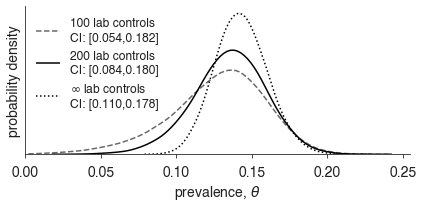

In [23]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,3))
ax.plot(x1,y1,'--',
        color='dimgrey',
       label='100 lab controls\nCI: [{},{}]'.format(
       np.round(CI1[0],3),
           np.round(CI1[1],3)))
ax.plot(x2,y2,
        color='black',
       label='200 lab controls\nCI: [{},{:.3f}]'.format(
       np.round(CI2[0],3),
           np.round(CI2[1],3)))
ax.plot(xi,yi,':',
        color='black',
       label='$\infty$ lab controls\nCI: [{:.3f},{:.3f}]'.format(
       np.round(CIi[0],3),
           np.round(CIi[1],3)))
ax.set_yticks([])
ax.set_ylabel('probability density')
ax.set_xlabel(r'prevalence, $\theta$')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.legend(fontsize=12,frameon=False)
finalize(ax,ignoreLegend=True)
fig.tight_layout()
# plt.savefig('Fig1.pdf')

# Figure 2

Data for this figure were run in 5 batches of MCMC, each of which saves to a .pkl file. 
The code below does *not* do any sampling but instead loads in samples already taken. 

To run sampling code, see `mcmc_survey_1.py`.

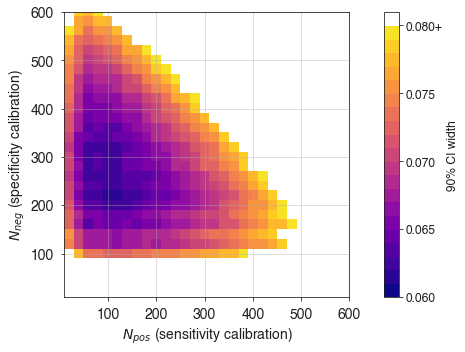

In [20]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,5))

N=1000
se = 0.93
sp = 0.98
dx = 20
x = np.arange(dx,600+1,dx)
X,Y,W1= pickle.load(open('W2mcmc1.pkl','rb'))
X,Y,W2= pickle.load(open('W2mcmc2.pkl','rb'))
X,Y,W3= pickle.load(open('W2mcmc3.pkl','rb'))
X,Y,W4= pickle.load(open('W2mcmc4.pkl','rb'))
X,Y,W5= pickle.load(open('W2mcmc5.pkl','rb'))
W = (W1+W2+W3+W4+W5)/5

cmap = plt.cm.plasma  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the -1 color entry to be white
cmaplist[-1] = (1, 1, 1, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.arange(0.06, 0.081, 0.001)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

im = ax.imshow(W,origin='lower',cmap=cmap,norm=norm)

# finalize(ax,ignoreLegend=True,)
ax.tick_params(direction='out')
ax.yaxis.label.set_size(14)
ax.xaxis.label.set_size(14)
ax.tick_params(axis='both', which='major', labelsize=14, pad=7)
ticks = np.arange(-1,len(x),5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_yticklabels(x[ticks].astype(int))
ax.set_xticklabels(x[ticks].astype(int))
ax.set_xlabel('$N_{pos}$ (sensitivity calibration)')
ax.set_ylabel('$N_{neg}$ (specificity calibration)')
ax.set_xlim([-0.5,29])
ax.set_ylim([-0.5,29])
cbar = fig.colorbar(im, ax=ax)
ax.grid(alpha=0.5)
cbar.set_ticks(bounds[::5])
tx = cbar.ax.get_yticklabels()
tx[-1].set_text(tx[-1].get_text()+'+')
cbar.ax.set_yticklabels(tx,fontsize=12)
cbar.set_label('90% CI width',fontsize=12)
plt.tight_layout()

# plt.savefig('Fig2.pdf')

# Figure 3

In [14]:
# survey
pos = 10
neg = 990

# lab calibration
# sense
tp = 100
fn = 0
# spec
tn = 95
fp = 5

In [15]:
dat_fig3 = {'field_pos':pos, 
       'field_n':pos+neg,
       'true_neg':tn, 
       'total_neg':tn+fp,
       'true_pos':tp,
       'total_pos':tp+fn}

In [16]:
samps = 100000
fit_fig3 = sm.sampling(data=dat_fig3, iter=int(2*samps/4),chains=4,n_jobs=1)

In [17]:
post_fig3 = fit_fig3.extract()
prev_fig3 = (post_fig3['p'])
se_fig3 = (post_1['sens'])
sp_fig3 = (post_1['spec'])
xf3,yf3,CIf3 = process(sp_fig3)

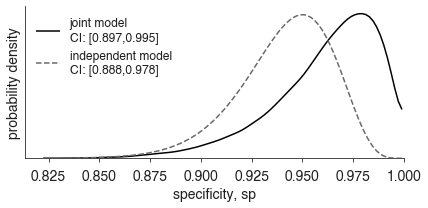

In [19]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,3))
ax.plot(xf3,yf3,
        color='black',
       label='joint model\nCI: [{:.3f},{:.3f}]'.format(
       np.round(CIf3[0],3),
           np.round(CIf3[1],3)))

ax.plot(xf3,beta.pdf(xf3,tn+1,fp+1),
        linestyle='--',
        color='dimgrey',
       label='independent model\nCI: [{:.3f},{:.3f}]'.format(
           beta.ppf(0.025,tn+1,fp+1),
           beta.ppf(0.975,tn+1,fp+1)
           ))
ax.set_yticks([])
ax.set_ylabel('probability density')
ax.set_xlabel(r'specificity, sp')
ax.set_ylim(bottom=0)
ax.set_xlim(right=1)
ax.legend(fontsize=12,frameon=False)
finalize(ax,ignoreLegend=True)
fig.tight_layout()
# plt.savefig('Fig3.pdf')